# Simulating t-tests in R
Andreas Dzemski




## Getting started

This note notebook simulates T-statistcs

$$
T = \frac{\hat{\beta}_1 - \beta_{1,0}}{SE(\hat{\beta}_1)}
$$

where $\beta_1$ and $SE(\hat{\beta}_1)$ are estimated from the model

$$
\texttt{income} = \beta_0 + \beta_1 \texttt{cost} + U.
$$

 
For each simulation run, the code draws random observations $(\texttt{cost}_i, U_i)$ for $i = 1, \ldots, n$ and computes the outcome $\texttt{income}_i$ according to the linear model above. Then, it estimates $\hat{\beta}_1$ and its standard error $SE(\hat{\beta}_1)$ based on the simulated sample. 

In this notebook, you can specify the true value of $\beta_1$, the hypothesized value $\beta_{1,0}$, and the sample size $n$, and see how the distribution of the T-statistic changes. These parameters do not fully specify the data-generating process - the missing ingredient is the joint distribution of $(\texttt{cost}, U)$. I have specified a distribution such that $\texttt{cost}$ is exogenous.

Do run the simulations, we need some helper functions that we load now:

In [61]:
source("helper_functions/helper_simulations.r")

This exposes the functions `simulate()` and `plot_simulation_results()` that we will use below. 

At this point, you can run all code in this notebook by clicking on the "Run All" button in the toolbar above. Everytime you make a change, you have to re-run the notebook to see the updated results.

## A first simulation

We start with a first simulation, and simulate a few samples under the null hypothesis. Under the null, we have $\beta_1 = \beta_{1,0}$. For simplicity, we set both to zero. We also set the sample size to $n=20$.


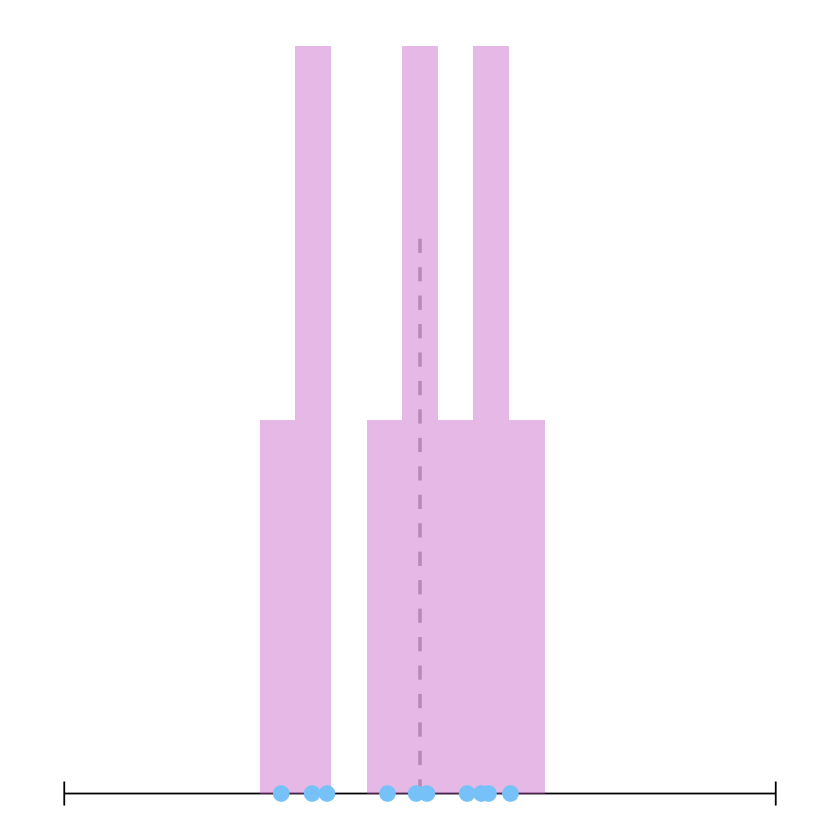

In [85]:
tstats <- simulate(
    num_simulations = 10, 
    true_beta1 = 0, 
    tested_beta1 = 0, 
    sample_size = 20
)

plot_simulation_results(tstats, point_per_observation = TRUE)

Every blue point represents a t-statistic, computed from one of our ten simulated samples. The histogram summarizes the distribution of the t-statistics. This simulation does not tell us much about the distribution of the t-statistic, every simulation draw is random and since we have only few draws, the observed distribution reflects simulation noise as much as the true distribution of the t-statistic. You can confirm this by re-running the simulation a few times by clicking the "Run All" button again and again: you will see that the blue points and the histogram change a lot from run to run.

When we increase the number of simulations, this problem goes away and we get a clearer picture of the distribution of the t-statistic under the null hypothesis.

Play around with the number of simulations. Try values like 100, 1,000, or 2,000 (enter them without the commas). You should observe that the simulated distribution of the t-statistic stabilizes, that is, it does not change much when you re-run the simulation. Of course, running more simulations takes more time.

In theory, we know that the distribution should be approximately standard normal under the null hypothesis in "sufficiently large" samples. To evaluate whether this happens in practice for a given sample size, we overlay the histogram with the standard normal density.

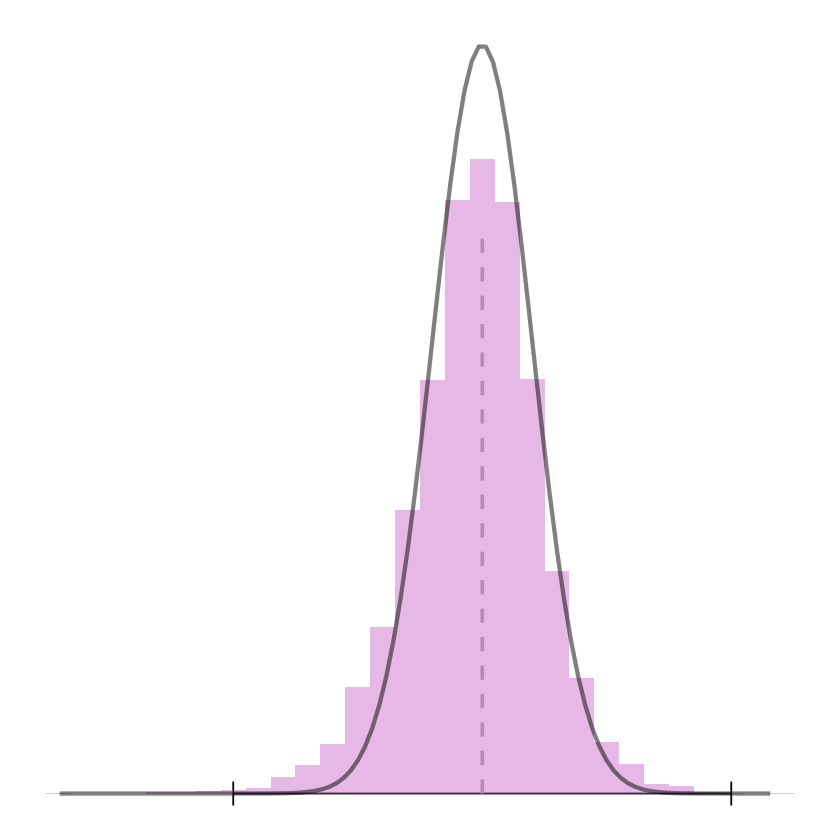

In [86]:
simulated_tstats <- simulate(
  num_simulations = 5000,
  true_beta1 = 0,
  tested_beta1 = 0,
  sample_size = 20
)

plot_simulation_results(simulated_tstats) +
  stat_function(fun = dnorm, color = "black", alpha = 0.5, size = 1.2)

As you can see, the standard normal density does not fit the simulated distribution perfectly. This is not surprising, the standard normal distribution approximation only holds exactly in large samples. Here, our sample is only of size $n=20$, which is quite small. In particular, you should see that the simulated distribution has slightly heavier tails than the standard normal distribution. That means that there is more probability mass allocated to extreme values of the t-statistic, and less mass in the center of the distribution.

Increase the sample size to confirm that the normal approximation works better in larger samples. Try values like 100, 500, 1,000 or even 5,000.

When we simulate a large number of t-statistics, the distribution of the t-statistic gives an accurate picture of the sampling distribution of the t-statistic in our setting. This distribution is called the _empirical distribution_ of the t-statistic. The normal density represents the _reference distribution_ that we use to determine the critical values of the t-test. 


## Empirical size of the t-test

How well the empirical distribution matches the reference distribution, in the sense of the histogram fitting the normal density, does not directly matter. What matters is whether the empirical size of the t-test, obtained by sampling from the empirical distribution of the t-statistic and comparing those values to the critical values from the reference distribution, matches the test’s nominal size.

This is something that we can directly check in our simulation. 

The following code is a little longer than the previous code blocks. Don't worry about that - you don't have to understand every line of code here. The only lines that you may want to change are the lines in the beginning where we set the nominal size and two sample sizes.


In [87]:
# Set nominal size of the test
alpha <- 0.05
# Set a small sample size
small_n <- 20
# Set a large sample size
large_n <- 2000
# Number of simulations
num_simulations <- 4000

crit_value <- qnorm(1 - alpha / 2)
cat(sprintf("Critical value for two-tailed test at alpha =%.2f is %.2f\n", alpha, crit_value))

sim_small_n <- simulate(
  num_simulations = num_simulations,
  true_beta1 = 0, # see, we are in the null hypothesis 
  tested_beta1 = 0, 
  sample_size = small_n
) |> 
  mutate(
    sample = "Small sample",
    n = small_n
  )

sim_large_n <- simulate(
  num_simulations = num_simulations,
  true_beta1 = 0, # see, we are in the null hypothesis 
  tested_beta1 = 0, 
  sample_size = large_n
) |> 
  mutate(
    sample = "Large sample",
    n = large_n
  )

size_simulations <- bind_rows(sim_small_n, sim_large_n) |> 
  mutate(
    reject_null = abs(tstat) > crit_value
  ) |> 
  group_by(sample, n) |>
  summarise(
    `empirical size` = mean(reject_null), .groups = "drop",
  ) |>
  mutate(
    `empirical relative to nominal size` = `empirical size` / alpha
  )

print(size_simulations)



Critical value for two-tailed test at alpha =0.05 is 1.96
# A tibble: 2 × 4
  sample           n `empirical size` `empirical relative to nominal size`
  <chr>        <dbl>            <dbl>                                <dbl>
1 Large sample  2000           0.0512                                 1.02
2 Small sample    20           0.119                                  2.37



You can play around with the sample sizes and the nominal level. You will see that the empirical size is off when the sample size is small, but is much closer to the nominal size when the sample size is large. 

In what way is the empirical size off in small samples? It is too large, that is, we are rejecting too often ("over-rejecting") and our probability of Type I error is larger than the prescribed nominal level. We are therefore not keeping our promise to control the probability of Type I error.

Why is it that the difference between the empirical distribution and the normal reference distribution leads to over-rejection? The reason is that the empirical distribution has heavier tails - since our rejection region is in the tails this means that we will reject more often under the empirical distribution than under the normal reference distribution. If the t-statistic followed the normal distribution exactly, we would reject exactly with probability $\alpha$ under the null hypothesis. 

This observation may lead you to speculate that the problem is more severe for smaller nominal levels (say, $
\alpha = 0.01$) than for larger nominal levels (say, $\alpha = 0.2$). Explore this idea by changing $\alpha$ in the code above.  

## Monte Carlo error

This section is optional - it explores the idea of simulating empirical distributions a little more deeply, but doesn't add any new insights about t-tests.

Looking at the rejection probability above for the large sample size, you will see that it is not exactly equal to the nominal size. There are two possible reasons for this discrepancy:
1. A difference between the empirical distribution and the reference distribution, even for the large sample size.
2. We are not simulating precisely enough.

Let's think about the second reason.

Computer simulations like the ones we have done so far are called _Monte Carlo simulations_. They are subject to simulation, or _Monte Carlo error_. 

The outcome of any one single simulation run is random, since we are drawing the data that we are computing the t-statistics from randomly. 

(Actually, computers cannot draw truly random numbers, they use so-called pseudo-random number generators. For our purposes, "pseudo-random samples" behave like truly random samples, so we ignore this subtlety here.)

Let $R$ denote the random variable that takes the value one if the t-test rejects in the simulation run, and zero otherwise. We can think of the simulation as drawing a large number of times, say $M$ times, from the distribution of $R$. We obtain a "sample" of $M$ independent draws $R_1, R_2, \ldots, R_M$. 

Let $p$ denote the probability that the test rejects under the empirical distribution of the t-statistic. By the law of large numbers, the average
$$
\hat{p}_M = \frac{1}{M} \sum_{m=1}^M R_m
$$
converges to 
$$
E[R] = \frac{1}{M} \sum_{m=1}^M E[R_m] = \frac{1}{M} \sum_{m=1}^M p = p.
$$
This allows us to use simulation to estimate $p$.

But how accurately are we estimating $p$? A measure of the accuracy of $\hat{p}_M$ is its variance (we are more interested in the standard deviation, but we have to get at the variance first). Since the $R_m$ are independent, we have
$$
Var(\hat{p}_M) = Var\left(\frac{1}{M} \sum_{m=1}^M R_m\right) = \frac{1}{M^2} \sum_{m=1}^M Var(R_m) = \frac{1}{M} Var(R).
$$
This shows us at least that the variance of the simulated rejection probability decreases with the number of simulations $M$. To make a more precise statement about the precision of our simulations, we have to determine $Var(R)$. Since $R$ is a Bernoulli random variable, we have
$$
Var(R) = p(1-p),
$$
where $p$ is the true rejection probability under the empirical distribution of the t-statistic. Obviously, we do not know $p$ - that is why we are simulating in the first place! We can deal with this in two ways. 

First, as a function of $p$, $p(1-p)$ is maximized at $p=0.5$ and takes a maximal value of $1/4$. Let's confirm this graphically:



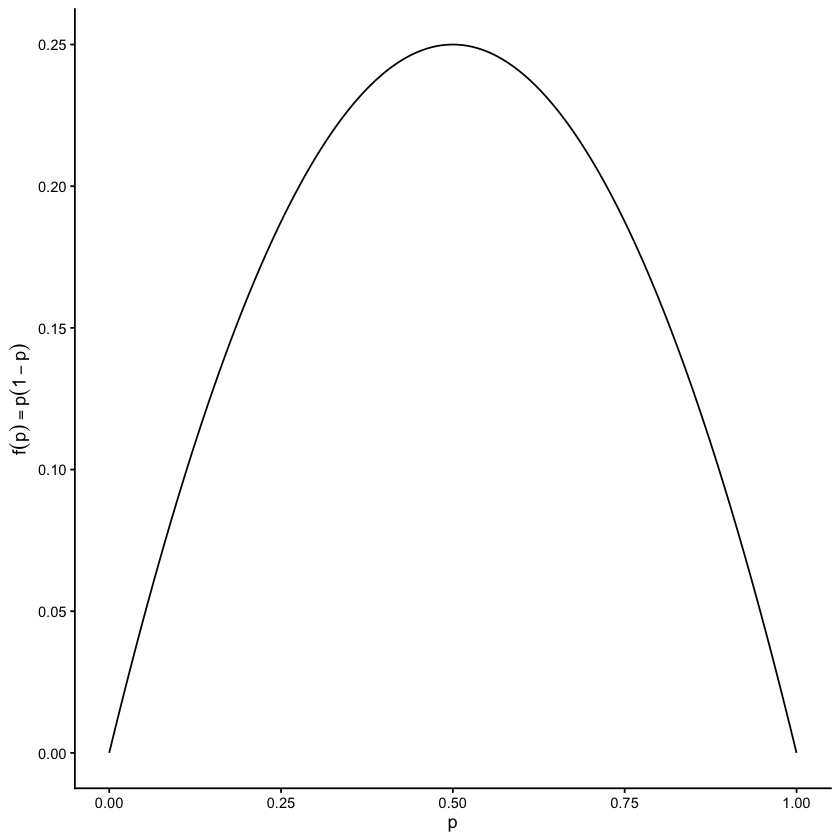

In [88]:
tibble(p = seq(0, 1, length.out = 500)) |> 
  mutate(
    f_of_p = p * (1 - p)
  ) |>
  ggplot(aes(x = p, y = f_of_p)) +
  geom_line() +
  ylab(expression(f(p) == p(1 - p))) +
  xlab("p") +
  theme_classic()

Therefore, the worst-case variance of our simulated probability is
$$
Var(\hat{p}_M) \leq \frac{1}{4M}.
$$

As an alternative approach, while we do not know $p$, we have an estimate of $p$, namely $\hat{p}_M$. We can therefore guess the variance of our simulated rejection probability to be 
$$
Var(\hat{p}_M) \approx \frac{1}{M} \hat{p}_M (1 - \hat{p}_M).
$$
You may find this approach counter-intuitive, after all, our goal is to quantify the imprecision of $\hat{p}_M$. Taking $\hat{p}_M$ to be precise enough to give us a good approximation of the variance may seem circular. There are theoretical arguments why this makes sense, but we will not go into them here.

The two approaches to quantify the variance lead to two quantifications of the standard deviation.

Let's add the Monte Carlo error quantification to our simulation above. We report two times the Monte Carlo standard deviation, in the spirit of providing a 95% confidence interval for the true rejection probability.

In [89]:
size_simulations |> 
  select(-`empirical relative to nominal size`) |> 
  mutate(
    `MC error (worst case)` = 2 * sqrt(0.25 / num_simulations), 
    `MC error (estimated)` = 2 * sqrt(`empirical size` * (1 - `empirical size`) / num_simulations)
  ) |>
  print()


# A tibble: 2 × 5
  sample        n `empirical size` MC error (worst case…¹ `MC error (estimated)`
  <chr>     <dbl>            <dbl>                  <dbl>                  <dbl>
1 Large sa…  2000           0.0512                 0.0158                0.00697
2 Small sa…    20           0.119                  0.0158                0.0102 
# ℹ abbreviated name: ¹​`MC error (worst case)`


These results should reassure you that simulation error is very small, and we can take our simulation results to give a fairly good picture of the true size of the test. 

If you want a lower Monte Carlo error, you can increase the number of simulations at the cost of longer computation time.